In [1]:
import os
import random
import numpy as np
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
# img_size = (240, 240)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

# Display input image #7
# Image.open(input_img_paths[9]).show()

# Display auto-contrast version of corresponding target (per-pixel categories)
# img = ImageOps.autocontrast(Image.open(target_img_paths[9]))
# img.show()


Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [2]:
class OxfordPetsDataset(Dataset):
    def __init__(self, input_img_paths, target_img_paths, img_size, max_dataset_len=None):
        self.input_img_paths = input_img_paths[:max_dataset_len] if max_dataset_len else input_img_paths
        self.target_img_paths = target_img_paths[:max_dataset_len] if max_dataset_len else target_img_paths
        self.img_size = img_size

    def __len__(self):
        return len(self.input_img_paths)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_img_paths[idx]).convert('RGB')
        target_img = Image.open(self.target_img_paths[idx]).convert('L')

        # Resize images
        input_img = input_img.resize(self.img_size, Image.BILINEAR)
        target_img = target_img.resize(self.img_size, Image.NEAREST)

        # Convert to tensors
        input_img = torch.tensor(np.array(input_img) / 255.0, dtype=torch.float32).permute(2, 0, 1)
        target_img = torch.tensor(np.array(target_img), dtype=torch.long)  # Change uint8 to long

        # Adjust target values
        target_img -= 1
        
        return input_img, target_img
    

In [3]:
# Split our img paths into a training and a validation set
val_samples = 2000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


In [4]:
# Create datasets
train_dataset = OxfordPetsDataset(train_input_img_paths[:2000], train_target_img_paths[:2000], img_size)
valid_dataset = OxfordPetsDataset(val_input_img_paths, val_target_img_paths, img_size)


In [5]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)


In [6]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        
        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            self.conv_block(3, 32, stride=2),
            self.conv_block(32, 64, stride=2),
            self.conv_block(64, 128, stride=2),
            self.conv_block(128, 256, stride=2)
        )
        
        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            self.upconv_block(256, 128),
            self.upconv_block(128, 64),
            self.upconv_block(64, 32),
            self.upconv_block(32, 32)
        )
        
        # Final classification layer
        self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)
        
    def conv_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        features = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            features.append(x)
        
        # Decoder
        for i, decoder_layer in enumerate(self.decoder):
            x = decoder_layer(x)
            if i < len(self.decoder) - 1:
                x = x + features[-i-2]  # Skip connection
        
        # Final classification
        x = self.final(x)
        return x
    

In [7]:
# Create model, loss function, and optimizer
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = torch.device("cpu")

print(f"Using device: {device}")

model = SegmentationModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
Using device: cuda


In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

val_losses = []  # 用於存儲每個 epoch 的驗證損失

# Training loop
num_epochs = 32
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        # print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
        # print(f"Target min: {targets.min()}, Target max: {targets.max()}")
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_losses.append(val_loss/len(valid_loader))  # 收集驗證損失

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(valid_loader):.4f}")
    
# Save the model
torch.save(model.state_dict(), "oxford_segmentation.pth")


Epoch 1/32, Train Loss: 0.8744, Val Loss: 0.7692
Epoch 2/32, Train Loss: 0.6500, Val Loss: 0.6238
Epoch 3/32, Train Loss: 0.5830, Val Loss: 0.6408
Epoch 4/32, Train Loss: 0.5343, Val Loss: 0.5515
Epoch 5/32, Train Loss: 0.4784, Val Loss: 0.5204
Epoch 6/32, Train Loss: 0.4360, Val Loss: 0.5460
Epoch 7/32, Train Loss: 0.3977, Val Loss: 0.5350
Epoch 8/32, Train Loss: 0.3680, Val Loss: 0.5572
Epoch 9/32, Train Loss: 0.3269, Val Loss: 0.5388
Epoch 10/32, Train Loss: 0.3048, Val Loss: 0.5440
Epoch 11/32, Train Loss: 0.2751, Val Loss: 0.5540
Epoch 12/32, Train Loss: 0.2525, Val Loss: 0.6396
Epoch 13/32, Train Loss: 0.2370, Val Loss: 0.5899
Epoch 14/32, Train Loss: 0.2217, Val Loss: 0.6062
Epoch 15/32, Train Loss: 0.2144, Val Loss: 0.6129
Epoch 16/32, Train Loss: 0.2057, Val Loss: 0.6948
Epoch 17/32, Train Loss: 0.1957, Val Loss: 0.6651
Epoch 18/32, Train Loss: 0.1874, Val Loss: 0.6698
Epoch 19/32, Train Loss: 0.1752, Val Loss: 0.6697
Epoch 20/32, Train Loss: 0.1687, Val Loss: 0.7058
Epoch 21/

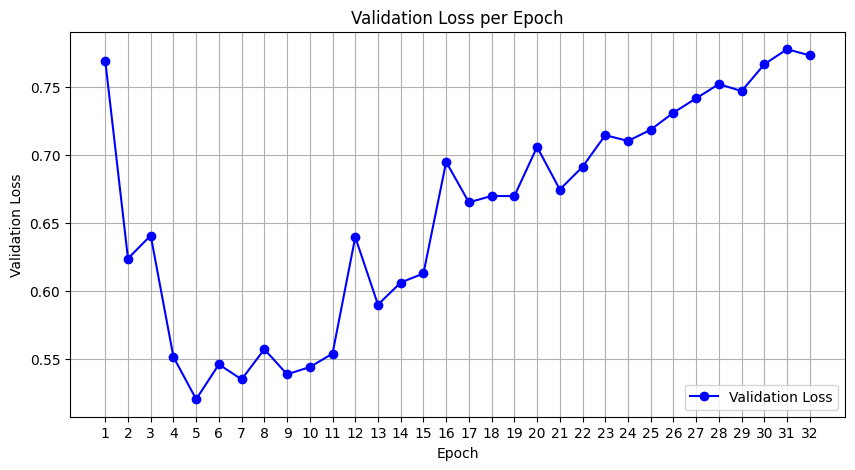

In [9]:
# 繪製驗證損失曲線
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', color='blue', label='Validation Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(range(1, num_epochs + 1))  # 設置 x 軸刻度
plt.grid()
plt.legend()
plt.show()

In [10]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Generate predictions for validation set
model.eval()
val_preds = []
with torch.no_grad():
    for inputs, _ in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        val_preds.extend(preds)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = val_preds[i]
    img = Image.fromarray((mask * 127).astype(np.uint8))
    img = ImageOps.autocontrast(img)
    return img


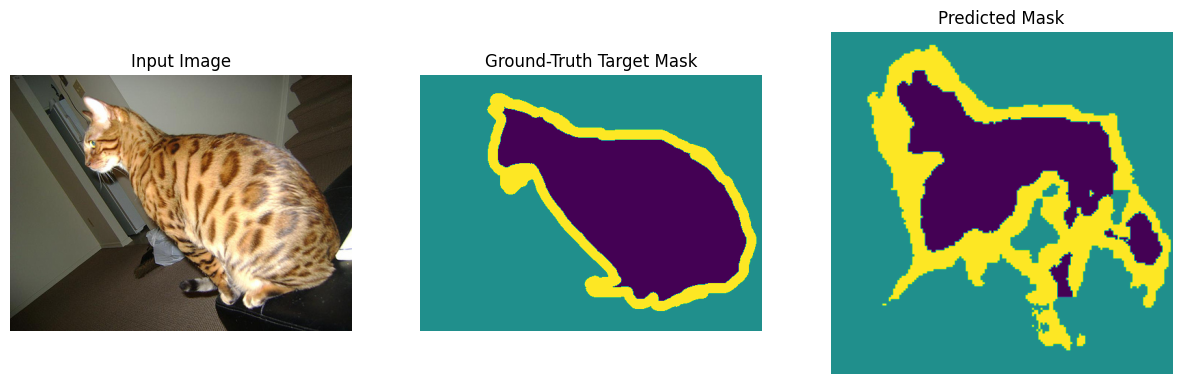

In [11]:
# Display results for validation image #10
i = 10

# Function to display images
def display_images(index):
    # Load images
    input_image = Image.open(val_input_img_paths[index])
    target_image = ImageOps.autocontrast(Image.open(val_target_img_paths[index]))
    
    # Display images
    plt.figure(figsize=(15, 5))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Input Image')
    plt.axis('off')

    # Ground-truth target mask
    plt.subplot(1, 3, 2)
    plt.imshow(target_image)
    plt.title('Ground-Truth Target Mask')
    plt.axis('off')

    # Predicted mask (assuming display_mask returns a numpy array or PIL image)
    plt.subplot(1, 3, 3)
    predicted_mask = display_mask(index)  # Ensure this function returns a suitable image
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Call the function to display images
display_images(i)
